# Statistical Analysis + ML Learning Methods
## Data Group 1 (MEMS DESIGN DATA)

Author: Yahriel Salinas-Reyes

## Importing basic, statistics, and machine learning packages

In [386]:
# Basic packages
import pandas as pd # pandas is used to load and manipulate data and for One-Hot Encoding
import numpy as np # data manipulation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors      

# Makes some plots look nicer
import seaborn as sns

# Statistical packages
import statsmodels.api as sm
from statsmodels.formula.api import ols   # ordinary least squares model 
import statsmodels.stats.multicomp        # option for ANOVA, not used yet

# The machine learning modules
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve 
from sklearn import svm
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn import preprocessing # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data

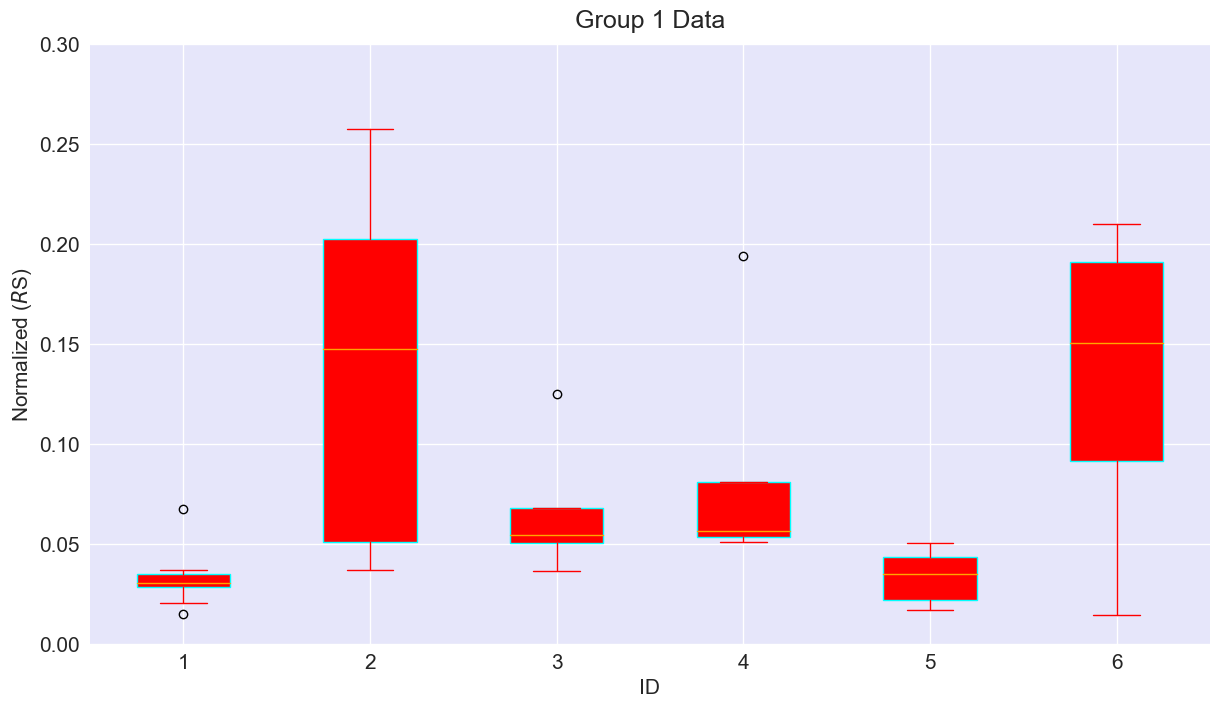

In [387]:
# Read In Data
df = pd.read_csv("MEMS Design Data.csv")
# Get the data into a pandas dateframe.  
#df = pd.read_csv('Yaya.csv', 
#                 header=1, ## NOTE: The second line contains column names, so we skip the first line
#                 sep='\t') ## NOTE: Pandas automatically detects delimeters, but it never hurts to be specific
#df.drop('Group', axis=0, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
#df.drop(columns=['Group', 'Set', 'AbsJ', 'J', 'I', 't', 'R'])
#df.drop(columns=['Group'])

df.head()

# this makes a box plot sorted by experiment
# boxplot is an axes object
# It was a hassle to figure out how to edit the colors for the boxes
# Turning on patch_artist applies some default colors 

boxplot = df.boxplot('GF', by='Set', vert=True, patch_artist=True,   
            boxprops=dict(facecolor='red', color='cyan'), # doesn't work 
            capprops=dict(color='red'),                   # works
            whiskerprops=dict(color='red'),               # doesn't work
            medianprops=dict(color='orange'),             # does not work
            figsize=(14,8))                               # works

fig = boxplot.get_figure()                                # a work around to get rid of annoying auto-title
fig.suptitle('')

boxplot.patch.set_facecolor('lavender')         # Changes plot background
# plt.style.use('seaborn') # Does not do anything

plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)
font = {'size': 15}
plt.xlabel('ID', font)
plt.ylabel(r'Normalized ($R$S)', font)
plt.ylim(0,0.3)
plt.title('Group 1 Data', fontsize=18, pad = 12)
plt.show()


- **Group**, Experimental Group Data
- **Set**, Sensor Sample #
- **ID**, Experimental Run #
- **B Area**, Paper Beam Surface Area
- **B Length**, Paper Beam Length
- **B Thickness**, Paper Beam Thickness
- **PR(nu)**, Poission's Ratio of Substrate Material
- **R Area**, PZR Cross-Sectional Area
- **R Length**, PZR Length
- **R Location**, PZR Location Along Beam
- **Contacts**, FM or SP Contact Pads
- **dR/dX**, Change in R/Change in X
- **GF**, Gauage Factor of Sensor
- **dR/R_0**, Relative Change in R
- **Strain**, Strain Along Beam
- **nR**, Normalized Strain Measurement




In [388]:
df.rename({'dR/dX' : 'Sensitivity'}, axis='columns', inplace=True)
df.rename({'dR/R_0' : 'Relative_Resistance'}, axis='columns', inplace=True)
df.head()
#df.drop('PR', axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
#df.drop('R Area', axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
#df.drop('R Length', axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
#df.drop('R Location', axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
#df.drop('Contacts', axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
#
# df.drop('nR', axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
df.Set



0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    2
11    2
12    2
13    2
14    2
15    3
16    3
17    3
18    3
19    3
20    4
21    4
22    4
23    4
24    4
25    5
26    5
27    5
28    5
29    5
30    5
31    6
32    6
33    6
34    6
35    6
Name: Set, dtype: int64

                  df    sum_sq   mean_sq          F        PR(>F)
C(B_Area)       11.0  0.050021  0.004547  12.197201  6.967872e-05
C(B_Thickness)   4.0  0.075000  0.018750  50.292662  2.120037e-07
C(R_Length)      4.0  0.004866  0.001216   3.262672  4.985178e-02
C(R_Location)    4.0  0.015410  0.003852  10.333217  7.331035e-04
Residual        12.0  0.004474  0.000373        NaN           NaN


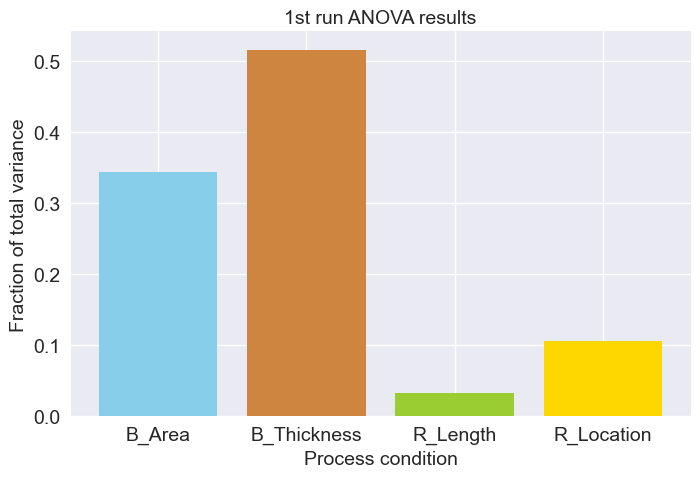

In [389]:
model = ols('GF ~ C(B_Area) + C(B_Thickness) + C(R_Length) + C(R_Location)', df).fit()

model.summary()
res = sm.stats.anova_lm(model, typ= 1)   # Need type 1 to agree with paper and with Matlab
print(res)     #  this write the model summary to the console

#  Now make the bar graph
objects = (df.columns[3],   # These are the column labels (factors)
           df.columns[5],
           df.columns[8],
           df.columns[9])

y_pos = np.arange(len(objects))  # this just makes an array [0, 1, 2, 3]
                                 # arrange makes evenly spaced values on a 
                                 # given interval.  Sort of expects integers

totalSSRnoRes = sum(res.sum_sq)-res.sum_sq[-1]  # for normalizing

performance = [res.sum_sq[0]/totalSSRnoRes,     # these are the bar lengths
               res.sum_sq[1]/totalSSRnoRes, 
               res.sum_sq[2]/totalSSRnoRes, 
               res.sum_sq[3]/totalSSRnoRes]

plt.figure(figsize=(8,5), dpi=100)                   
plt.bar(y_pos, performance,       
        align='center', 
        width=0.8,              # default is 0.8
        alpha=1.0,              # this is transparency, 1.0 is solid
        color=['skyblue', 'peru', 'yellowgreen', 'gold'])

plt.xticks(y_pos, objects)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#font = {'size': 18}
plt.xlabel('Process condition', fontsize=14)
plt.ylabel('Fraction of total variance', fontsize=14)
plt.title('1st run ANOVA results', fontsize=14)

plt.style.use('seaborn')        # this makes a lightgrey background with a nice grid

plt.show()


                  df      sum_sq    mean_sq         F    PR(>F)
C(B_Length)     11.0  215.251279  19.568298  1.620581  0.209576
C(B_Thickness)   4.0  253.174928  63.293732  5.241777  0.011202
C(R_Length)      4.0  263.620351  65.905088  5.458040  0.009701
C(R_Location)    4.0   78.999713  19.749928  1.635623  0.228991
Residual        12.0  144.898351  12.074863       NaN       NaN


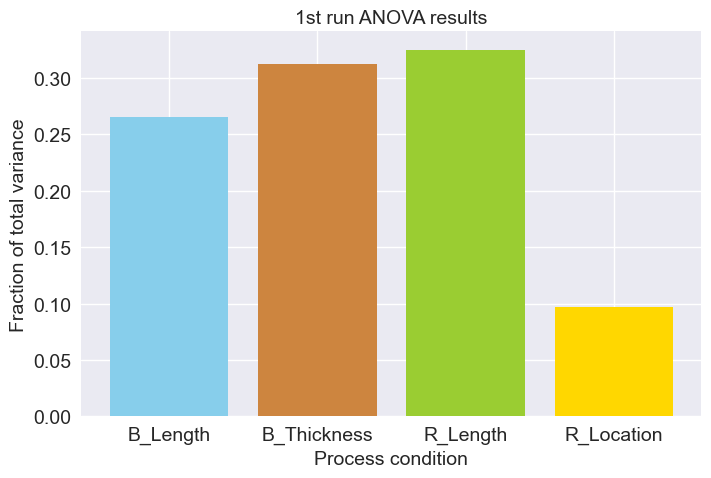

In [390]:
model = ols('Relative_Resistance ~ C(B_Length) + C(B_Thickness) + C(R_Length) + C(R_Location)', df).fit()

model.summary()
res = sm.stats.anova_lm(model, typ= 1)   # Need type 1 to agree with paper and with Matlab
print(res)     #  this write the model summary to the console

#  Now make the bar graph
objects = (df.columns[4],   # These are the column labels (factors)
           df.columns[5],
           df.columns[8],
           df.columns[9])

y_pos = np.arange(len(objects))  # this just makes an array [0, 1, 2, 3]
                                 # arrange makes evenly spaced values on a 
                                 # given interval.  Sort of expects integers

totalSSRnoRes = sum(res.sum_sq)-res.sum_sq[-1]  # for normalizing

performance = [res.sum_sq[0]/totalSSRnoRes,     # these are the bar lengths
               res.sum_sq[1]/totalSSRnoRes, 
               res.sum_sq[2]/totalSSRnoRes, 
               res.sum_sq[3]/totalSSRnoRes]

plt.figure(figsize=(8,5), dpi=100)                   
plt.bar(y_pos, performance,       
        align='center', 
        width=0.8,              # default is 0.8
        alpha=1.0,              # this is transparency, 1.0 is solid
        color=['skyblue', 'peru', 'yellowgreen', 'gold'])

plt.xticks(y_pos, objects)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#font = {'size': 18}
plt.xlabel('Process condition', fontsize=14)
plt.ylabel('Fraction of total variance', fontsize=14)
plt.title('1st run ANOVA results', fontsize=14)

plt.style.use('seaborn')        # this makes a lightgrey background with a nice grid

plt.show()

## Cross validation on the first run data  
Hyperparameter selection using 10-fold cross validation
1. Vary $\gamma$ between 0 and 1.0 with *C* = 40 and $\epsilon$ = 0.1   
2. Vary C between 1 and 100 with $\gamma$ = 0.5 and $\epsilon$ = 0.1     
3. Vary $\epsilon$ between 0 and 1 with *C* = 40 and $\gamma$ = 0.5  

Note: cross-validation is done with `learning_curve` on scaled data using `preprocessor.scale`  This scales the factors settings and target to zero mean and unit variance. 

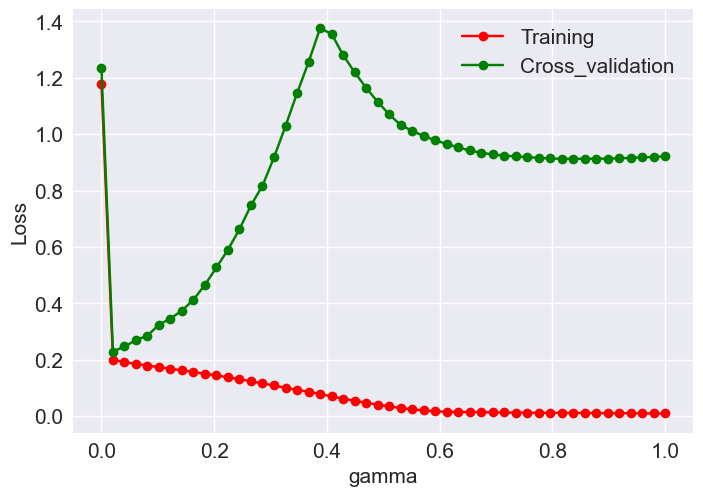

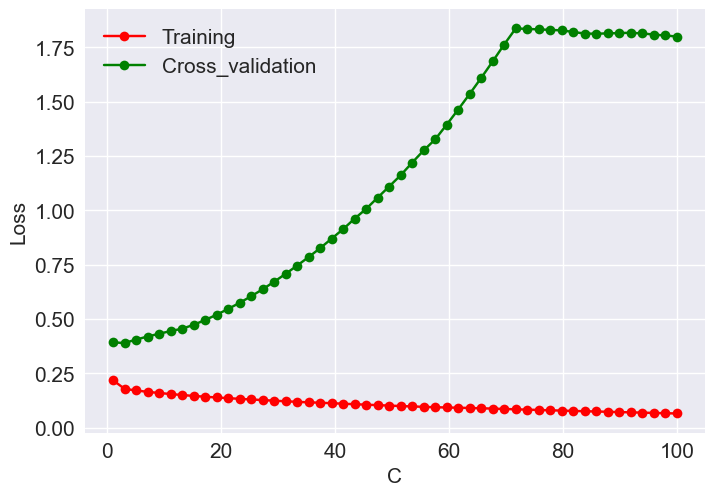

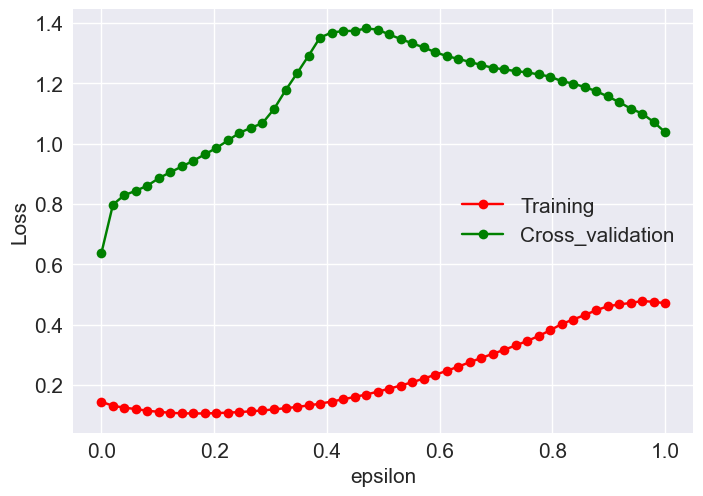

In [391]:
# Select data from dataframe and put into X matrix (parameters) and y (target)
data = df[['B_Length','B_Thickness','Strain','Relative_Resistance']]
target = df[['GF']]
X = data       # is nx4 matrix with 4 columns for the 4 factors   
y = target     # is nx1 column vector for n observations

#test gamma value between 0 and 1
# cv = 10 is for 10 fold cross validation. 
param_range = np.linspace(0,1,50)   # set the range for parameter gamma
train_loss, test_loss = validation_curve( 
        svm.SVR(kernel='rbf', C=40),
        preprocessing.scale(X.values), preprocessing.scale(y.values.ravel()), param_name='gamma',
        param_range=param_range, cv=10, 
        scoring = 'neg_mean_squared_error')
# Use negative to 
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

# make the learning curve for gamma
plt.figure(1)
plt.plot(param_range, train_loss_mean, 'o-', color="r", label="Training")
plt.plot(param_range, test_loss_mean, 'o-', color="g", label="Cross_validation")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font = {'size': 15}
plt.xlabel("gamma", font)
plt.ylabel("Loss", font)
plt.legend(loc="best", fontsize=15)
plt.style.use('seaborn')
plt.show()


#test C value
param_range = np.linspace(1,100,50)   # set the range for parameter C, between 0 and 100
train_loss, test_loss = validation_curve(
        svm.SVR(kernel='rbf', gamma=0.3), 
        preprocessing.scale(X.values), preprocessing.scale(y.values.ravel()), param_name='C',
        param_range=param_range, cv=10, 
        scoring = 'neg_mean_squared_error')
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)
# use minus to avoid negatives

# make the learning curve for C
plt.figure(2)
plt.plot(param_range, train_loss_mean, 'o-', color="r", label="Training")
plt.plot(param_range, test_loss_mean, 'o-', color="g", label="Cross_validation")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font = {'size': 15}
plt.xlabel("C", font)
plt.ylabel("Loss", font)
plt.legend(loc="best", fontsize=15)
plt.style.use('seaborn')
plt.show()


#test epsilon value
param_range = np.linspace(0,1,50)   # set the range for parameter gamma
train_loss, test_loss = validation_curve( 
        svm.SVR(kernel='rbf', C=40, gamma=0.3),
        preprocessing.scale(X.values), preprocessing.scale(y.values.ravel()), param_name='epsilon',
        param_range=param_range, cv=10, 
        scoring = 'neg_mean_squared_error')
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

# make the learning curve for epsilon
plt.figure(3)
plt.plot(param_range, train_loss_mean, 'o-', color="r", label="Training")
plt.plot(param_range, test_loss_mean, 'o-', color="g", label="Cross_validation")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font = {'size': 15}
plt.xlabel("epsilon", font)
plt.ylabel("Loss", font)
plt.legend(loc="best", fontsize=15)
plt.style.use('seaborn')
plt.show()

# Should figure out how to make 3 subplots

 Hyperparameters from the cross validation: 
>$\gamma = 0.5$  
$C = 40$  
$\epsilon = 0.1$  (value chosen based on both training and cross validation data)

## SVR on the first round experimental data  
Comparing the measured and predicted FoMs for the first round of data.

In [392]:
# Make a list of variables for machine learning
names = ('B_Length','B_Thickness','Strain','Relative_Resistance')
variables = df.loc[:, names]           

# this constructs the SVR model using the hyperparameters from the previous step
reg_FoM = Pipeline([('scl', StandardScaler()),
                    ('clf', svm.SVR(kernel='rbf', gamma=0.5, 
                                    C=40, epsilon = 0.1,
                                    verbose=True))])
#  Pipeline somehow allows several commands to be strung together
#  scl = Standard scalar
#  clf = ??  Not sure what this does
#  svm = Support vector machine
#  SVR = Support Vector Regression
#  rbf = Radial basis function kernel 
#  gamma, C, and epsilon are hyperparameters for the rbf kernal

# Fit the variables to the FoM
reg_FoM.fit(variables, df.GF)     

# Add a column to the dataframe with the prediceted values
df['FoM_pred_svm'] = reg_FoM.predict(variables)


[LibSVM]

In [393]:
#df.FoM_pred_svm.unique
#X.values

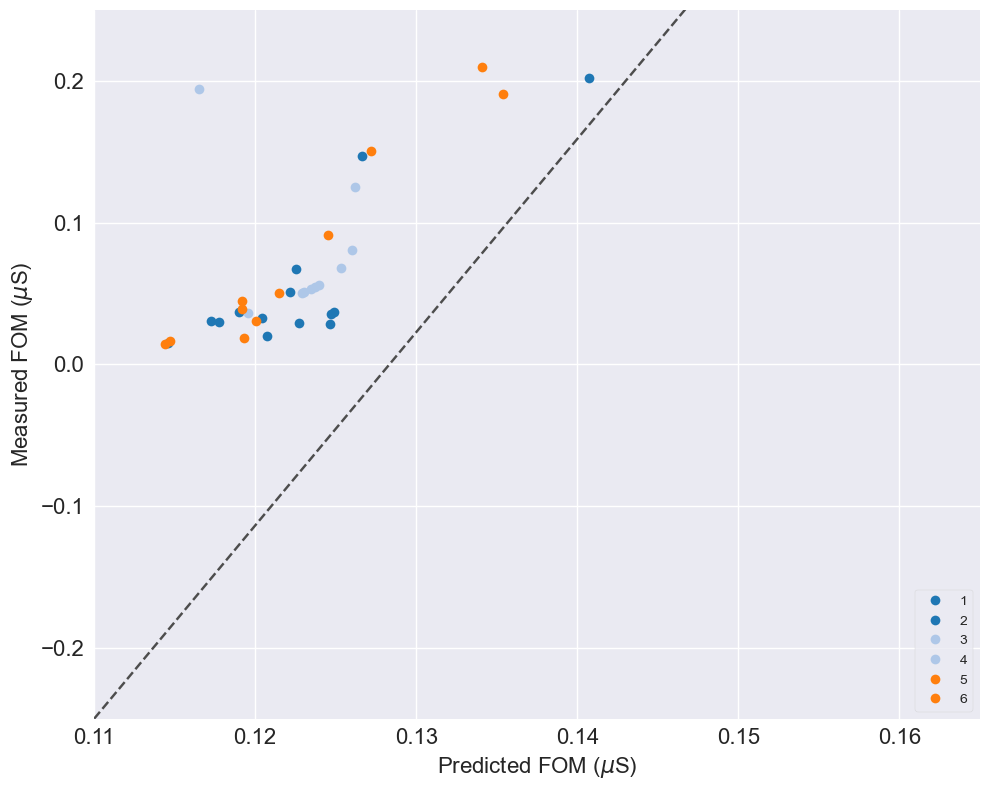

<Figure size 800x550 with 0 Axes>

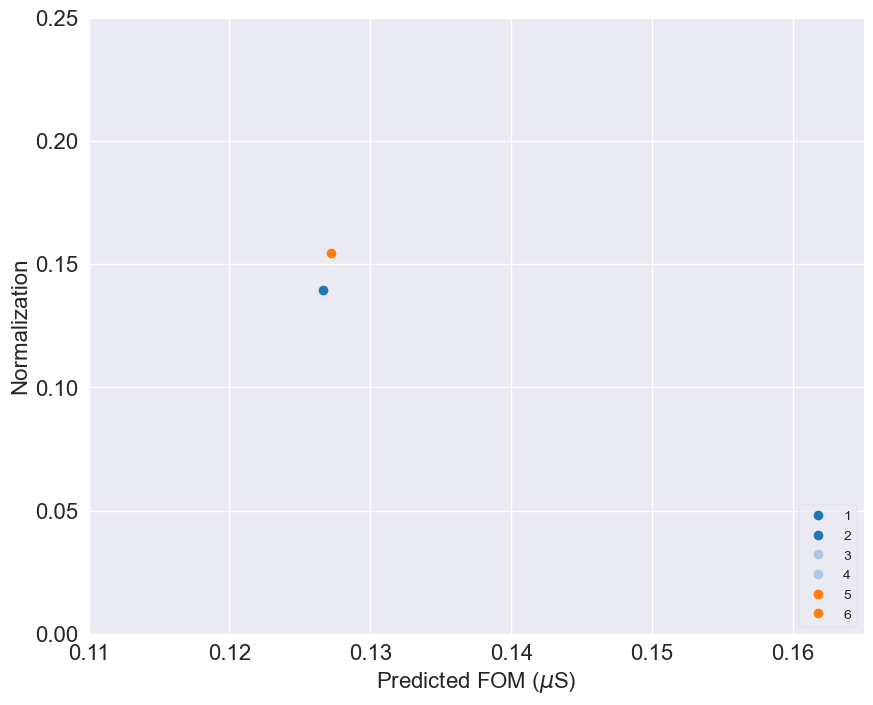

In [394]:

# Making unique colors for the 32 datasets
colors = plt.cm.tab20(np.linspace(0, 1, 39)[0:len(df.Set.unique())])
color_dic = {label: color for label, color in zip(df.Set.unique(), colors)}

# associates a color with the labels in the dataframe.  
df['color'] = df.Set.map(color_dic)    

#  Now make the plot of predicted vs. measured FoM
fig, ax1 = plt.subplots(1, 1, 
                        clear=True,      
                        num='Predicted vs measured FoM',   # sets the label at the top of the window
                        figsize=(10, 8))   # 
for label, data in df.groupby('Set'):   # loop through to catch each experimental condition
    plt.plot('FoM_pred_svm', 'GF', 'o',  
             color=data['color'].iloc[0],
             data=data,                   # refers back to reference to dataframe
             label=label)
plt.legend(loc='lower right', frameon=True)     # make a legend
plt.plot([.11, .165], [-.25, .5], ls="--", c=".3")  # This draws a dotted line
plt.autoscale(enable=False)                    # turn off autoscale
plt.xlim(.11,0.165)                             # setting plot range here
plt.ylim(-.25,.25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
font = {'size': 16}
ax1.set_xlabel(r'Predicted FOM ($\mu$S)', font)
ax1.set_ylabel(r'Measured FOM ($\mu$S)', font)

plt.style.use('seaborn')                 # Best style for this plot

plt.tight_layout()                       # finally, show the plot, 
plt.show()                               # tight means push plot to edges of the window

#  this is to make plot of Normalized measured-predicted vs. measured 
plt.figure(3)  
fig, ax1 = plt.subplots(1, 1, 
                        clear=True,       
                        num='Predicted vs measured FoM',   # sets the label at the top of the window
                        figsize=(10, 8))   # 
df['min'] = (df.GF-df.FoM_pred_svm)/df.GF
for label, data in df.groupby('Set'):   # loop through to catch each experimental condition
    plt.plot('FoM_pred_svm', 'min', 'o',  
             color=data['color'].iloc[0],
             data=data,                   # refers back to reference to dataframe
             label=label)
plt.legend(loc='lower right', frameon=True)    
plt.xlim(.11,.165)
plt.ylim(0,0.25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
font = {'size': 16}
ax1.set_ylabel('Normalization', font)
ax1.set_xlabel(r'Predicted FOM ($\mu$S)', font)

plt.style.use('ggplot')
plt.style.use('seaborn')                 

#plt.tight_layout()                       # finally, show the plot, 
plt.show()                               # tight means push plot to edges of the window

In [426]:
#Size of the plot grid
u_len = 5    # 4 columns, one each of the 4 temperature levels
v_len = 12    # 2 rows, one for each Cu/(Cu+Zn) level (0.65 and 0.85)

#the levels for the plots in the grid
us = np.array([.26,.52,.78,1.04,1.30])    # Beam Thickness
vs = np.array([19.2,24.2,29.2,34.2,37.6,39.2,44.2,49.2,50,54.2,59.2,64.2])  #Beam Length

#x and y axes for the contour plots in the grid
x_len, y_len = 100, 100            # number of points to make the contour plot
xs = np.linspace(-.01, 1.15, x_len)   # vary Strain between 60 and 120 minutes
ys = np.linspace(-10, 30, y_len)# Relative_Resistance range, this will be y axis

 
vi, ui, xi, yi = names 
names = ('B_Length', 'B_Thickness', 'Strain', 'dR')




In [427]:
df.query

<bound method DataFrame.query of     Group  Set  ID  B_Area  B_Length  B_Thickness   PR  R_Area  R_Length  \
0       1    1   1     642      64.2         0.26  0.5   46.25         8   
1       1    1   2     592      59.2         0.26  0.5   46.25         8   
2       1    1   3     542      54.2         0.26  0.5   46.25         8   
3       1    1   4     492      49.2         0.26  0.5   46.25         8   
4       1    1   5     442      44.2         0.26  0.5   46.25         8   
5       1    1   6     392      39.2         0.26  0.5   46.25         8   
6       1    1   7     342      34.2         0.26  0.5   46.25         8   
7       1    1   8     292      29.2         0.26  0.5   46.25         8   
8       1    1   9     242      24.2         0.26  0.5   46.25         8   
9       1    1  10     192      19.2         0.26  0.5   46.25         8   
10      1    2  11     376      37.6         0.26  0.5   46.25         8   
11      1    2  12     376      37.6         0.52  0.5 

c:\Users\yahri\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\yahri\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\yahri\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\yahri\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


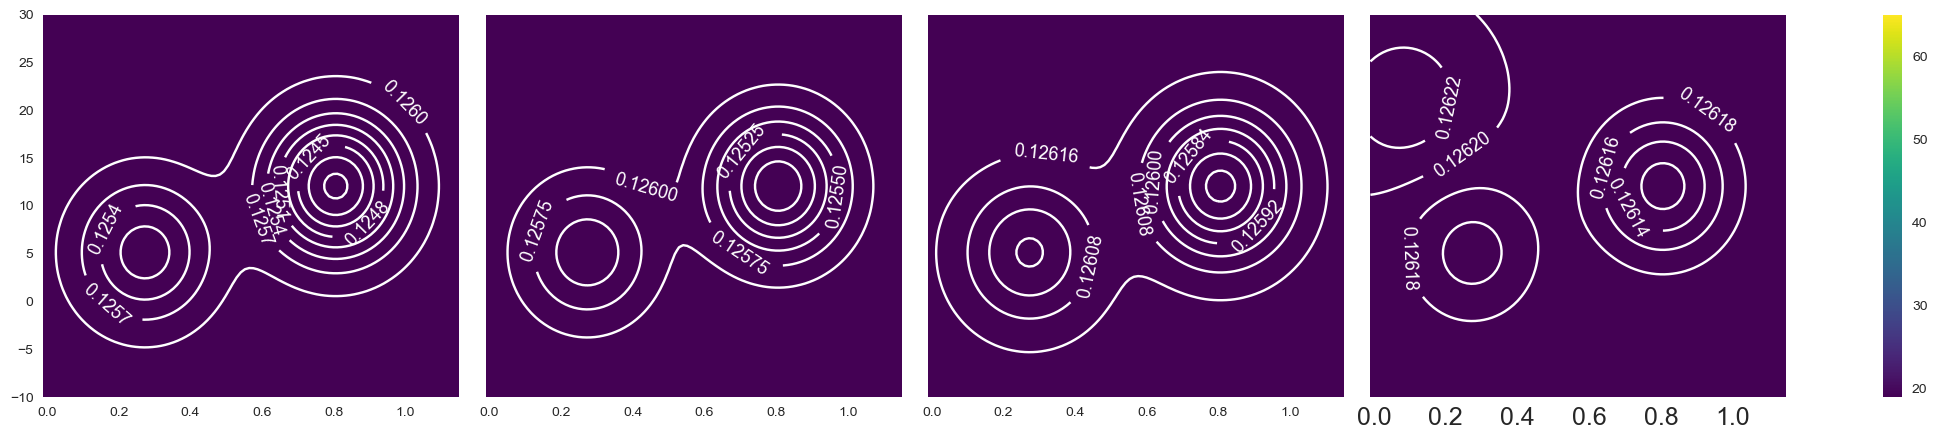

In [431]:


# Actually making each row manually
fig, axs = plt.subplots(nrows=1, ncols=4,      # 2 row, 4 columns, present position=1
                        sharex=True, sharey=True,   # Same x and y axes
                        clear=True, 
                        num='Support Vector Machine Regression, FOM',        # text at top of window
                        figsize=(20, 4.5))  

for ax, u in zip(axs, us): 
    # zip puts column vectors together, two loops: ax = axs[0,0] and v=0.65; ax = axs[0,1] and v=0.85 
    xm,ym = np.meshgrid(xs,ys)    # makes some sort of mesh, 
    # Edit here to change between 0.65 and 0.85
    vm = 0.65 * np.ones_like(xm)  # change Cu_content at each run to obtain different occasions.
# can also use loop to achieve, will be more complicated
    um = u * np.ones_like(xm)
    # This set the third value you need to send to the predictor
    r = np.c_[vm.flatten(), um.flatten(), xm.flatten(), ym.flatten()] 
    # flatten matrices into column vectors 
    c = reg_FoM.predict(r).reshape(x_len, y_len) 
    # feed flatteed mesh r to the predication algorithm, then reshape the predictions back to a matrix
  
    # Make a contour map
    cmap = ax.contour(xs, ys, c, vmin=19, vmax=65, cmap='gray_r')
    plt.clabel(cmap, inline=1, fontsize=13) # this specifies the contour labels
    # Make a value map inline=1 can also wrote as inline=True
    pmap = ax.pcolormesh(xs, ys, c, 
                    shading='gouraud',
                    vmin=19, vmax=65, 
                    cmap='viridis') # this makes the nice colors 
    df.B_Length = pd.to_numeric(df.B_Length)
    
    # Edit here to change between 0.65 and 0.85
    for label, data in df.query('B_Length == @u and B_Thickness == 1.30').groupby('Set'): # finds the cases
        ax.plot('Strain', 'Relative_Resistance', 'o', 
                color=data['color'].iloc[0], # used same color for the data points
                data=data.iloc[0], 
                mec='k', # with black outline
                mew=0.5, # line thickness
                label=label)
        ax.legend(loc='upper left', frameon=True) 
        font={'size': 18}
        ax.set_ylabel(f'{yi} ([])', font) # sets text for y axis label
        ax.set_xlabel(f'{xi} (%)', font) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.colorbar(pmap, ax=axs, fraction=0.05) # Finally, add color bar.
plt.show() # and display